In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pylab

%matplotlib inline

In [2]:
n = 100
x = np.linspace(-3, 3, n)
y = np.exp(x/5) + np.cos(x)

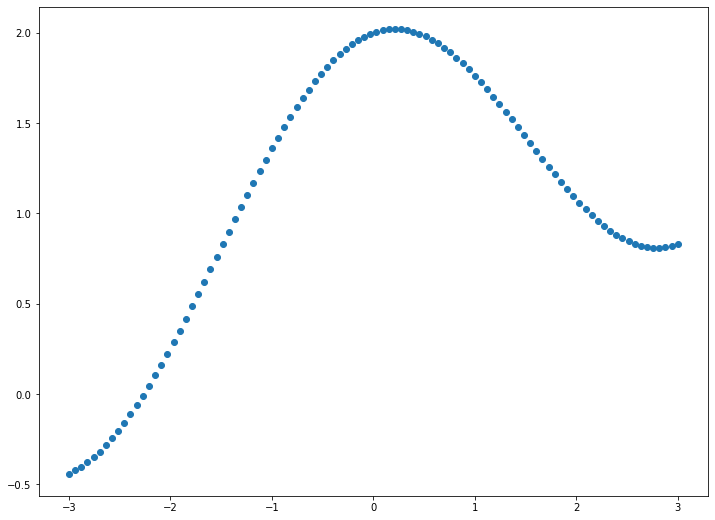

In [3]:
plt.plot(x, y, 'o');

In [4]:
def basis_functions(w, x):
    basis = np.ndarray((n, m))
    for i in range(n):
        basis[i] = np.sqrt(1 + ((x[i] - w[m:m*2]) / w[m*2:m*3]) ** 2)
    return np.sum(basis * w[:m], axis=1)

In [5]:
def basis_functions_deriv(w, x):
    deriv = np.zeros((3 * m, n))
    for i in range(3 * m):
        if i < m: # a
            deriv[i] = np.sqrt(1+((x - w[m+i]) / w[m*2+i])**2)
        elif i < 2*m: # b
            deriv[i] = (w[i-m]*(w[i]-x))/((w[i+m]**2)*np.sqrt(1+((x - w[i]) / w[m+i])**2))
        elif i < 3*m: # d
            kv = np.sqrt(1+((x - w[i-m]) / w[i])**2)
            deriv[i] =(-w[i-2*m]*((x-w[i-m])**2))/((w[i]**3)*kv)
    return deriv

In [6]:
def basis_functions_hess(w, x):
    hess = np.zeros((3 * m, 3 * m, n))
    for i in range(3 * m):
        if i < m:
            a = w[i]
            b = w[i + m]
            d = w[i + 2 * m]
            kv = np.sqrt(abs(1 + ((x - b) / (d ** 2))))
            hess[i, i + m] = (b - x) / (kv * d ** 2)
            hess[i, i + 2 * m] = (-((x - b) ** 2)) / (kv * d ** 3)
        elif i < 2 * m:
            a = w[i - m]
            b = w[i]
            d = w[i + m]
            kv = np.sqrt(abs(1 + ((x - b) / (d ** 2))))
            hess[i, i - m] = (b - x) / (kv * d ** 2)
            hess[i, i] = (a / (kv * d ** 2)) * (1 - ((x - b) ** 2) / ((kv ** 2) * (d ** 2)))
            hess[i, i + m] = ((a * (x - b))/((kv * d ** 3))) * (2 - ((x - b) ** 2) / ((kv ** 2) * (d ** 2)))
        elif i < 3 * m:
            a = w[i - 2 * m]
            b = w[i - m]
            d = w[i]
            kv = np.sqrt(abs(1 + ((x - b) / (d ** 2))))
            hess[i, i - 2 * m] = (-((x - b) ** 2)) / (kv * d ** 3)
            hess[i, i - m] = ((a * (x - b)) / ((kv * d ** 3))) * (2 - ((x - b) ** 2) / ((kv ** 2) * (d ** 2)))
            hess[i, i] = (a * ((x - b) ** 2) * (3 - ((x - b) ** 2)) / kv ** 2)/(kv * d ** 4)
    return hess

In [7]:
def error_func(w):
    basis = basis_functions(w, x)
    error = 0
    for i in range(n):
        error += (basis[i] - yn[i]) ** 2
    return error

def error_func_deriv(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    error_deriv = np.zeros(3 * m)
    for i in range(3 * m):
        error_deriv[i] = 2 * np.sum((basis - yn) * basis_deriv[i], axis=0)
    return error_deriv

def error_func_hess(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    basis_hess = basis_functions_hess(w, x)
    error_hess = np.zeros((3 * m, 3 * m))
    for i in range(3 * m):
        for j in range(3 * m):
            error_hess[i, j] = 2 * np.sum((basis_deriv[i] * basis_deriv[j] + basis_hess[i, j] * (basis - yn)), axis=0)
    return error_hess

In [8]:
m = 3
a = np.random.normal(loc=0,scale=3,size=m)
b = np.random.normal(loc=0,scale=1,size=m)
d = np.random.normal(loc=0,scale=1,size=m)
w = np.concatenate((a,b,d))
np.set_printoptions(precision=3, suppress=True)

print('Начальные параметры')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(w[i], w[i + m], w[i + 2 * m]))

Начальные параметры
a:   3.387   b:  -0.660   d:  -1.451
a:   3.140   b:   1.431   d:  -0.297
a:   4.522   b:   0.900   d:   0.513


Начальная ошибка: 208666.2212725974


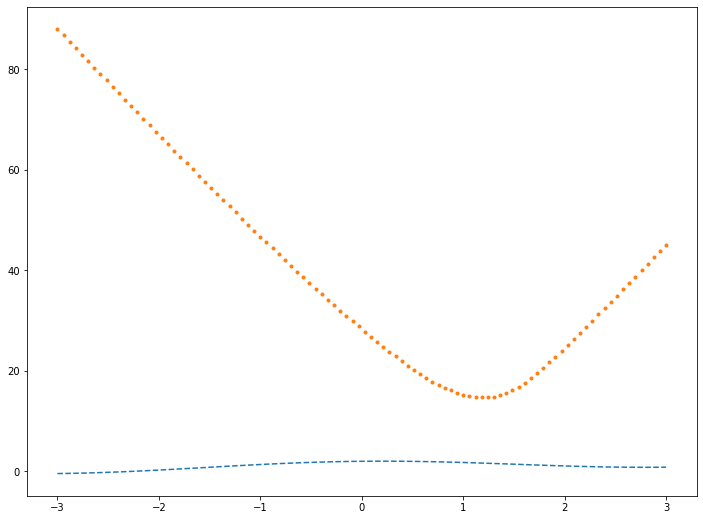

In [9]:
plt.plot(x, y, '--')
plt.plot(x, basis_functions(w, x), '.');
print('Начальная ошибка:', error_func(w))

## 0 порядка

Optimization terminated successfully.
         Current function value: 0.328827
         Iterations: 2016
         Function evaluations: 2945

Параметры аппроксимирующей функции после оптимизации
a:   2.256   b:  -1.940   d:  -3.858
a:  -0.000   b:  -0.543   d:  -0.000
a:  -0.251   b:   0.363   d:   0.462

Ошибка после минимизации: 0.3288267133594833

CPU times: user 1.42 s, sys: 5.94 ms, total: 1.43 s
Wall time: 1.43 s


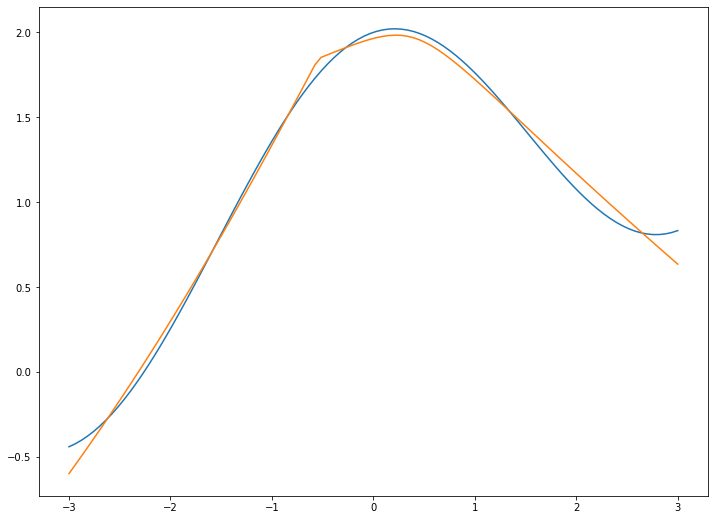

In [10]:
%%time

res = minimize(error_func, w, method='Nelder-Mead',options={'maxiter':10000,'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')

for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i + m], res.x[i + 2 * m]))

print()
print('Ошибка после минимизации:', res.fun)
print()

plt.plot(x, y);
plt.plot(x, basis_functions(res.x, x));

Optimization terminated successfully.
         Current function value: 0.658764
         Iterations: 28
         Function evaluations: 2903

Параметры аппроксимирующей функции после оптимизации
a: -14.720   b:   2.079   d:  -1.309
a:   0.505   b:   9.578   d:  -0.464
a:   7.499   b:   2.004   d:   0.854

Ошибка после минимизации: 0.6587635360804701

CPU times: user 1.38 s, sys: 9.05 ms, total: 1.39 s
Wall time: 1.39 s


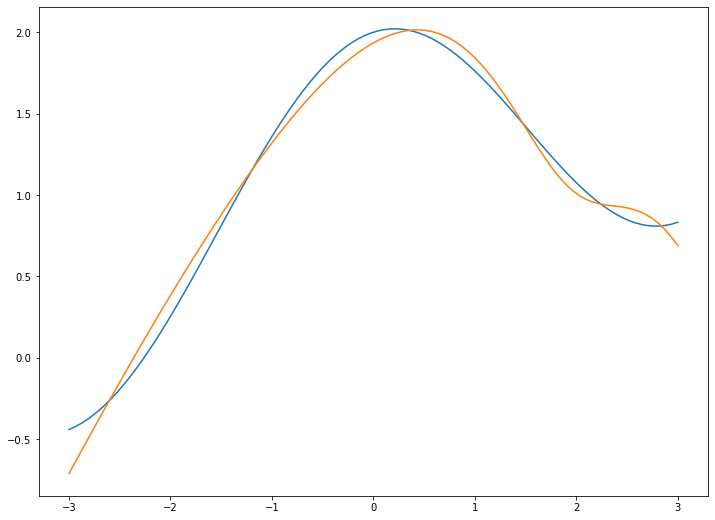

In [11]:
%%time

res = minimize(error_func, w, method='powell',options={'maxiter':10000,'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
    
print()
print('Ошибка после минимизации:', res.fun)
print()

plt.plot(x, y);
plt.plot(x, basis_functions(res.x, x));

## 1 порядка

         Current function value: 0.201356
         Iterations: 465
         Function evaluations: 656
         Gradient evaluations: 652

Параметры аппроксимирующей функции после оптимизации
a:  -1.379   b:   0.088   d:  -0.887
a:  -0.000   b:   4.834   d:   0.000
a:   5.714   b:   1.098   d:   3.718

Ошибка после минимизации: 0.20135581518561735

CPU times: user 701 ms, sys: 7.46 ms, total: 709 ms
Wall time: 708 ms


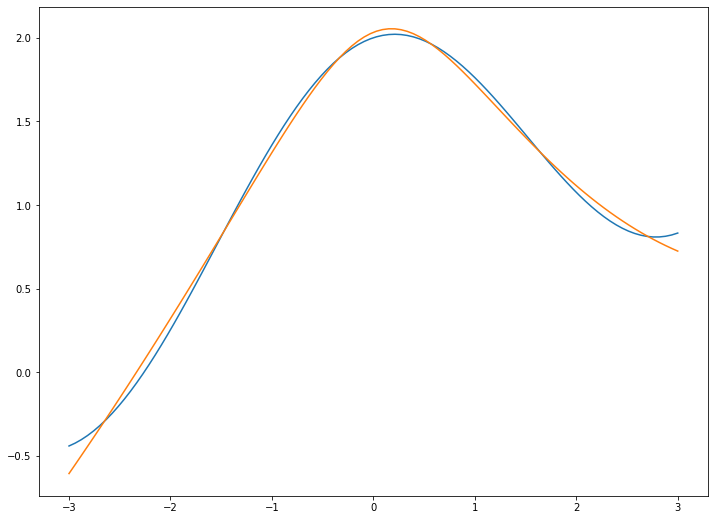

In [12]:
%%time

res = minimize(error_func, w, method='BFGS', jac=error_func_deriv, options={'maxiter':10000, 'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')

for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i + m], res.x[i + 2*m]))
    
print()
print('Ошибка после минимизации:', res.fun)
print()

plt.plot(x, y)
plt.plot(x, basis_functions(res.x, x));

         Current function value: 0.314895
         Iterations: 266
         Function evaluations: 3551
         Gradient evaluations: 354

Параметры аппроксимирующей функции после оптимизации
a:  -0.519   b:  -0.009   d:  -0.530
a:  -1.322   b:  41.154   d:   1.233
a:  43.340   b:   7.552   d:  18.726

Ошибка после минимизации: 0.31489463622979785

CPU times: user 1.73 s, sys: 12.7 ms, total: 1.74 s
Wall time: 1.74 s


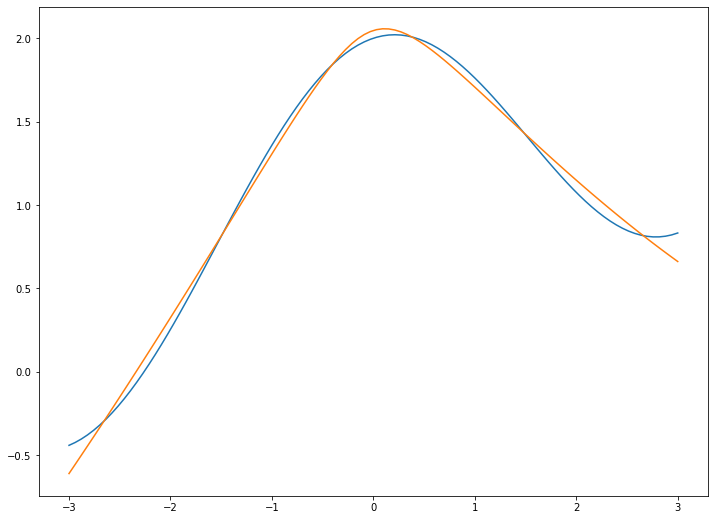

In [13]:
%%time

res = minimize(error_func, w, method='BFGS', options={'maxiter':10000, 'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')

for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i + m], res.x[i + 2*m]))
    
print()
print('Ошибка после минимизации:', res.fun)
print()

plt.plot(x, y)
plt.plot(x, basis_functions(res.x, x));

## 2 порядка

Optimization terminated successfully.
         Current function value: 0.316823
         Iterations: 1405
         Function evaluations: 1792
         Gradient evaluations: 1792
         Hessian evaluations: 1405

Параметры аппроксимирующей функции после оптимизации
a:  -0.578   b:  -0.078   d:  -0.562
a:   0.034   b:   0.715   d:  -3.216
a:   2.323   b:  -1.851   d:   3.733
Ошибка после минимизации: 0.3168227425749073
CPU times: user 3.47 s, sys: 20.7 ms, total: 3.49 s
Wall time: 3.49 s


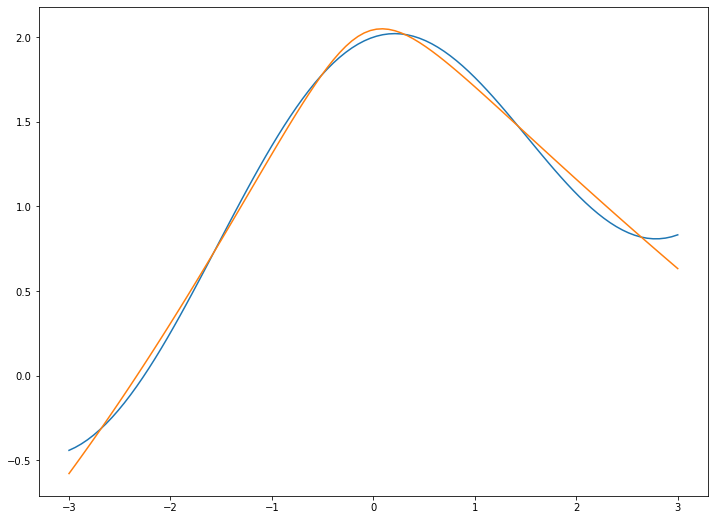

In [14]:
%%time

res = minimize(error_func, w, method='Newton-CG', jac=error_func_deriv, hess=error_func_hess, 
               options={'maxiter':10000, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y);
plt.plot(x, basis_functions(res.x, x));

/Users/mir/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.18684689929537635
            Iterations: 95
            Function evaluations: 983
            Gradient evaluations: 95

Параметры аппроксимирующей функции после оптимизации
a:   5.000   b:  -0.613   d:  -1.731
a:  -1.301   b:   0.137   d:  -0.882
a:  -1.573   b:  -0.698   d:   0.922

Ошибка после минимизации: 0.18684689929537635

CPU times: user 497 ms, sys: 9.38 ms, total: 506 ms
Wall time: 501 ms


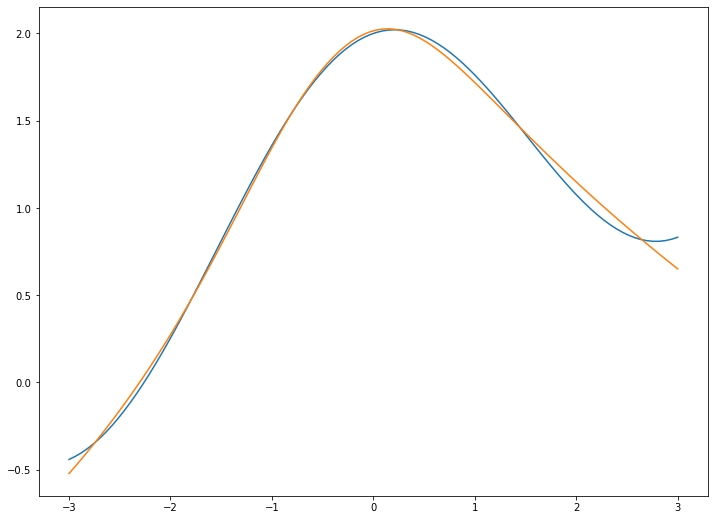

In [15]:
%%time
# с ограничениями

b1 = (-5,5)
b2 = (-3,3)
b3 = (-3,3)
bnds = (b1, b1, b1, b2, b2, b2, b3, b3, b3)
res = minimize(error_func, w, method='SLSQP', bounds=bnds, options={'maxiter':10000, 'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')

for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))

print()
print('Ошибка после минимизации:', res.fun)
print()

plt.plot(x, y)
plt.plot(x, basis_functions(res.x, x))